In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
filename = '/content/drive/MyDrive/birdclef-2022/test_soundscapes/soundscape_453028782.ogg'

##EDA

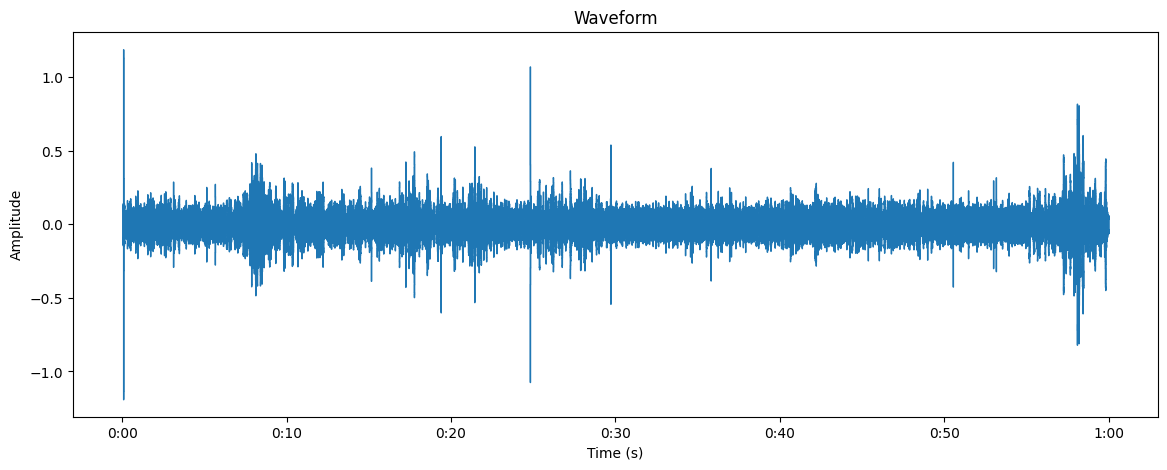

In [3]:
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(filename)

In [4]:
import librosa
audio_file_path='/content/drive/MyDrive/birdclef-2022/test_soundscapes/soundscape_453028782.ogg'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [5]:
print(librosa_audio_data)

[0.10309302 0.12085493 0.11119884 ... 0.01632767 0.01211889 0.0307934 ]


In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 2584)


In [7]:
mfccs

array([[-230.93256  , -185.7106   ,  -35.493336 , ..., -263.2751   ,
        -264.1869   , -259.63373  ],
       [  86.90895  ,   15.453638 ,  -16.337523 , ...,   21.64749  ,
          30.71319  ,   29.224594 ],
       [  33.235817 ,   20.953613 ,   -4.2891774, ...,   26.325537 ,
          27.627096 ,   31.156437 ],
       ...,
       [   2.93525  ,    5.9548864,    8.972105 , ...,    8.203438 ,
           1.7885054,    5.2159605],
       [   1.0928017,   -4.4775167,   -3.156262 , ...,    2.435331 ,
          -2.2301085,   -1.9611787],
       [   1.757138 ,    5.441839 ,   12.397434 , ...,    2.9494445,
           3.4249854,    1.1593249]], dtype=float32)

In [ ]:
data_folder = '/content/drive/MyDrive/birdclef-2022/a1'

def features_extractor(file):
    try:
        audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        return mfccs_scaled_features
    except Exception as e:
        print(f"Error in {file}: {e}")
        return None

In [ ]:
extracted_features = []

for root, dirs, files in os.walk(data_folder):
    for file in tqdm(files):
        if file.endswith('.ogg'):
            file_path = os.path.join(root, file)
            class_label = os.path.basename(root)
            try:
                data = features_extractor(file_path)
                if data is not None:
                    extracted_features.append([data, class_label])
            except Exception as e:
                print(f"Failed to extract features for {file_path}: {e}")

##SMOTE

In [8]:
import re
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [ ]:
df = pd.read_csv('extracted_audio_features_Total.csv')

def clean_and_convert_feature(feature_string):
    cleaned_string = feature_string.strip('[]').strip()

    cleaned_string = re.sub(r'\s+', ',', cleaned_string)

    feature_array = list(map(float, cleaned_string.split(',')))

    return feature_array

df['feature'] = df['feature'].apply(clean_and_convert_feature)

X = df['feature'].tolist()
y = df['class']

X, y = shuffle(X, y, random_state=42)

X = np.array(X)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_res, y_res)

resampled_df = pd.DataFrame({'feature': X_res.tolist(), 'class': y_res})

resampled_df.to_csv('resampled_data.csv', index=False)

##MODEL TRAINING


In [9]:
df = pd.read_csv('resampled_data.csv')

In [10]:
df.head()

,feature,class
0,"[-588.28186, 113.23836, 20.560604, 26.531742, ...",dunlin
1,"[-220.33952, 124.02964, 14.670247, 26.121185, ...",rudtur
2,"[-338.91528, 41.17189, -75.436302, -1.4589304,...",gadwal
3,"[-455.62057, 83.994965, 41.370667, 48.184292, ...",rudtur
4,"[-329.94485, 83.134865, 6.2074561, 46.532822, ...",sposan


In [11]:
Y = df['class']
from sklearn.preprocessing import LabelEncoder

lab = LabelEncoder()
Y = lab.fit_transform(Y)
print(Y)

[ 45 123  50 ... 150 150 150]


In [12]:
num_classes = df['class'].nunique()
num_classes

151

In [13]:
import ast
X = df['feature'].apply(ast.literal_eval)

X = np.array(X.tolist())

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=1)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, Y_train)

Y_pred = dt_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9003090507726269
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       152
           1       0.98      1.00      0.99       168
           2       0.99      1.00      0.99       165
           3       0.98      1.00      0.99       160
           4       1.00      1.00      1.00       146
           5       0.89      1.00      0.94       141
           6       1.00      1.00      1.00       160
           7       0.93      1.00      0.97       142
           8       0.82      0.87      0.84       162
           9       0.99      1.00      0.99       174
          10       0.23      0.10      0.14       150
          11       0.91      0.95      0.93       152
          12       0.79      0.65      0.71       161
          13       0.86      0.83      0.85       138
          14       0.99      1.00      1.00       137
          15       0.98      1.00      0.99       158
          16       0.98     

##MODEL EXPORTING

In [16]:
import joblib

joblib.dump(dt_model, 'Mark_1.pkl')

print("Best model saved to 'Mark_1.pkl'")

Best model saved to 'Mark_1.pkl'


##Implementation

In [17]:
import joblib

with open('Mark_1.pkl', 'rb') as file:
    model = joblib.load(file)

In [19]:
import librosa
audio_file_path='/content/drive/MyDrive/birdclef-2022/test_soundscapes/soundscape_453028782.ogg'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [20]:
test = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
test_scaled_features = np.mean(test.T, axis=0)

In [21]:
test_scaled_features = test_scaled_features.reshape(1, -1)
test_scaled_features = np.array(test_scaled_features.tolist())

In [22]:
test_scaled_features.shape

(1, 40)

In [23]:
model.predict(test_scaled_features)

array([53])

In [24]:
output = lab.inverse_transform(model.predict(test_scaled_features))
print(output)

['gnwtea']
